# Diseases MLR and corr with phenotypes 

Last modification: 09/08/2022

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from statsmodels.formula.api import ols, logit
from datetime import datetime
import seaborn as sns

DATE = datetime.now().strftime("%Y-%m-%d")

In [115]:
file_info_name='pheno_info_main.csv'
pheno_info_file = '/SSD/home/sofia/retina-phenotypes/complementary/disease_association/'+str(file_info_name)
display_info=True
ventile='ventile5'
diseases_file ='/NVME/decrypted/scratch/multitrait/UK_BIOBANK_ZERO/diseases_cov/2022_07_08_'+str(ventile)+'_diseases_cov.csv'
pheno_file ='/NVME/decrypted/scratch/multitrait/UK_BIOBANK_ZERO/participant_phenotype/2022_08_03_'+str(ventile)+'_corrected_z.csv'
output_dir ='/SSD/home/sofia/retina-phenotypes/complementary/disease_association/'

In [116]:
if file_info_name=='pheno_info_sup.csv':
    list_phenotypes=['AVScore_all', 'tau1_all', 'tau1_artery', 'tau1_vein', 'tau2_all', 'tau2_artery', 'tau2_vein', 
                     'tau4_all', 'tau4_artery', 'tau4_vein', 'D_std', 'D_A_std', 'D_V_std', 'D_median_CVMe', 'D_CVMe', 
                     'D_CVMe_A', 'D_CVMe_V', 'N_median_main_arteries', 'N_median_main_veins', 'arcLength_artery', 'arcLength_vein', 
                     'bifurcations', 'VD_orig_all', 'VD_orig_artery', 'VD_orig_vein', 'ratio_VD', 'slope', 'slope_artery', 'slope_vein', 
                     'mean_angle_taa', 'mean_angle_tva', 'medianCenter1_artery', 'medianCenter1_vein', 'medianCenter2_artery', 'medianCenter2_vein', 
                     'eq_CRAE', 'eq_CRVE', 'median_CRAE', 'median_CRVE', 'ratio_CRAE_CRVE', 'ratio_median_CRAE_CRVE', 'medianDiameter_all',
                     'medianDiameter_artery','medianDiameter_vein', 'ratio_AV_medianDiameter']
    
if file_info_name=='pheno_info_main.csv':
    list_phenotypes=["tau1_artery", "tau1_vein", "D_A_std", "D_V_std", "bifurcations", "VD_orig_artery", "VD_orig_vein", 
                     "ratio_VD", "mean_angle_taa" , "mean_angle_tva", "eq_CRAE", "eq_CRVE", "ratio_CRAE_CRVE",
                     "medianDiameter_artery", "medianDiameter_vein", "ratio_AV_medianDiameter"]

### 1 - Read diseases:

In [117]:
df_diseases=pd.read_csv(diseases_file, sep=',')

#### Read diseases info

In [118]:
inf = pd.read_csv(pheno_info_file)
### NOTE: Delete vascular_heart_problems since I am not sure of what the different values are:
#inf.drop(inf[(inf['name']=='vascular_heart_problems_00')].index, inplace=True)
##### Delete alcohol_intake_frequency_00
#inf.drop(inf[(inf['name']=='alcohol_intake_frequency_00')].index, inplace=True)

# Lists of phenotypes
list_diseases = inf['name'].values

list_diseases_bin = inf.loc[inf['dtype']=='bin', 'name'].values # binary phenotypes
list_diseases_con = inf.loc[inf['dtype']=='con', 'name'].values # continuous phenotypes
list_diseases_cat = inf.loc[inf['dtype']=='cat', 'name'].values # categorical phenotypes

##### Number of cases and controls per disease

Number of nans and ratio nans/no_nans:
-  DBP :  81017 0.0103
-  SBP :  81016 0.0103
-  PR :  81017 0.0103
-  date_reported_atherosclerosis :  459 0.9944
-  date_disorders_arteries_arterioles :  412 0.995
-  pulse_wave_arterial_stiffness_index_00 :  66468 0.188
-  HDL_cholesterol :  72281 0.117
-  LDL_direct :  76283 0.0681
-  Triglycerides :  76373 0.067
-  HbA1c :  75694 0.0753
-  alcohol_intake_frequency_00 :  81680 0.0022
-  Pack_year_smok :  23231 0.7162
-  eye_amblyopia_00 :  2200 0.9731
-  eye_presbyopia_00 :  24755 0.6976
-  eye_hypermetropia_00 :  11996 0.8535
-  eye_myopia_00 :  23732 0.7101
-  eye_astigmatism_00 :  7865 0.9039
-  eye_diabetes_00 :  746 0.9909
-  BMI :  81507 0.0043


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  from ipykernel import kernelapp as app
/SSD/home/sofia/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/SSD/home/sofia/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/SSD/home/sofia/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was depr

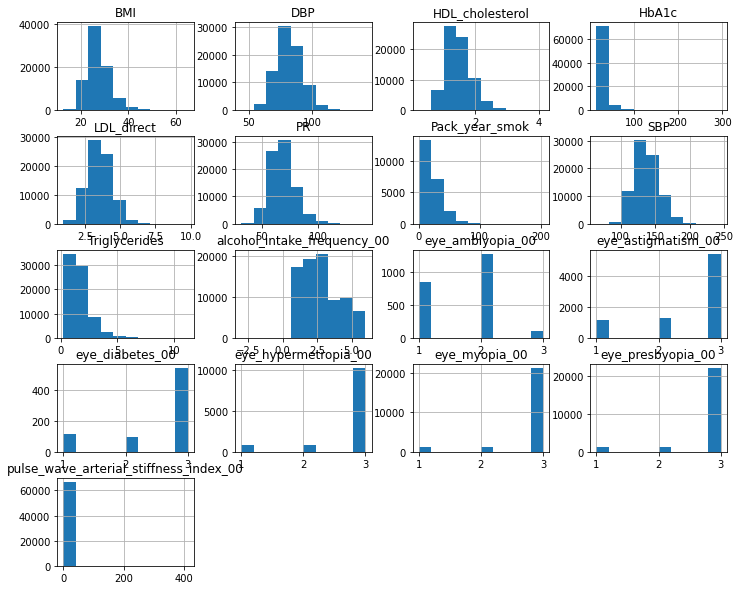

In [119]:
def N_of_nans_and_nonans(df_,disease):
    print('- ', disease,': ', 
          len(df_[disease]) - df_[disease].isna().sum(),
          (df_[disease].isna().sum()/len(df_[disease])).round(4))#, '\n')
if display_info==True:
    print('Number of nans and ratio nans/no_nans:')
    for disease_name in list_diseases:
        N_of_nans_and_nonans(df_diseases,disease_name)
        #plt.hist(df_diseases[disease_name])
        #plt.title(disease_name)
        #plt.show()
df_diseases_red = df_diseases[list_diseases]
fig = plt.figure(figsize = (12,10))
ax = fig.gca()
df_diseases_red.hist(ax = ax) 
plt.savefig(output_dir+ str(DATE)+'_MLRdiseases_hist.jpg', facecolor='white', bbox_inches='tight', pad_inches=0.1, dpi=150)


### 2 - Phenotypes:

In [120]:
### Read phenos
df_pheno=pd.read_csv(pheno_file, sep=',')

In [121]:
### Just to double-check: Replace -999 by np.nan
df_pheno = df_pheno.replace(-999.00, np.nan)
#print(df_pheno.isna().sum())

In [122]:
## Rename to eid to make the merge
df_pheno.rename(columns={'Unnamed: 0': 'eid'}, inplace=True)

### 3 - Merge diseases and phenotpyes

In [123]:
### Delete nans
#df_phenotypes=df_pheno.dropna()
#print('Delete subjects with nans, len before and after :',len(df_pheno), len(df_phenotypes))

In [124]:
df_pheno_dise=df_pheno.merge(df_diseases, how='left', on='eid')
print('Len BEFORE merge: pheno size , diseases size: ', len(df_pheno), len(df_diseases))
print('Len AFTER merge: ', len(df_pheno_dise))
#print(df_pheno_dise.columns)

Len BEFORE merge: pheno size , diseases size:  77115 81859
Len AFTER merge:  77115


## Filtrate only by the phenotypes and diseases of interest

In [125]:
list_phenos_diseases = list_phenotypes+list(list_diseases)

In [126]:
df_pheno_dise=df_pheno_dise[list_phenos_diseases]
df_pheno_dise

,tau1_artery,tau1_vein,D_A_std,D_V_std,bifurcations,VD_orig_artery,VD_orig_vein,ratio_VD,mean_angle_taa,mean_angle_tva,...,HbA1c,alcohol_intake_frequency_00,Pack_year_smok,eye_amblyopia_00,eye_presbyopia_00,eye_hypermetropia_00,eye_myopia_00,eye_astigmatism_00,eye_diabetes_00,BMI
0,-0.014589,1.169884,0.643480,0.912407,-0.882606,-0.034287,-0.648550,0.659063,0.026629,0.433526,...,19.1,4.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,18.9947
1,0.436273,1.564541,1.048687,-0.472586,-0.891035,-1.073063,-1.070843,-0.311907,NaN,NaN,...,36.3,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.9238
2,-0.001302,-0.051543,-0.628146,-0.789148,0.728931,0.648034,0.563089,0.229803,0.499851,-1.124371,...,36.3,2.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,26.4266
3,-0.066754,2.053665,-0.220528,-0.301639,-0.635511,-0.734972,-1.136659,0.288663,1.678741,NaN,...,39.3,4.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,26.5690
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,65.1,2.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,35.7445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,40.2,2.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,24.8557
77111,2.649257,-0.510072,-0.471703,-0.059277,-0.481274,0.284583,-1.197317,1.710748,-0.878541,-0.000944,...,30.8,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.2372
77112,-0.244132,0.055489,-0.277703,-0.414637,2.199730,2.037428,2.141887,0.329875,-0.183317,0.233806,...,35.2,1.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,25.9431
77113,1.567324,0.125204,0.743502,0.066245,0.029521,0.335816,-0.201911,0.572771,0.741470,0.968176,...,46.7,2.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,32.6575


## 4 - Correlation

In [127]:
import seaborn as sns

def corr(x, y, **kwargs):
    # Calculate the value
    coef = np.corrcoef(x, y)[0][1]
    # Make the label
    label = r'$\rho$ = ' + str(round(coef, 2))
    # Add the label to the plot
    ax = plt.pyplot.gca()
    ax.annotate(label, xy=(0.2, 0.95), size=20, xycoords=ax.transAxes)

In [128]:
matrix_total = df_pheno_dise.corr().round(1)
plt.figure(figsize=(10, 10), 
           dpi = 900) 
sns.heatmap(matrix_total, annot=True, vmax=1, vmin=-1, center=0, annot_kws={'size': 3}, cmap='vlag')

<AxesSubplot:>

### 4 - MLR

In [129]:
### Double check the numbers:
#print(df_pheno_dise_cov['age_cataract_00'].value_counts(), df_pheno_dise_cov['age_macular_deg_diag'].value_counts())

In [130]:
for col in df_pheno_dise.columns:
    # Make variables that start with "age_" binary (0 in NaN, 1 if not NaN)
    if col.startswith('age_'):
        df_pheno_dise.loc[df_pheno_dise[col].notna(), col] = 1
        df_pheno_dise.loc[df_pheno_dise[col].isna(), col] = 0

    elif col.startswith('date_'):
        df_pheno_dise.loc[df_pheno_dise[col].notna(), col] = 1
        df_pheno_dise.loc[df_pheno_dise[col].isna(), col] = 0

    # Same for variables starting with "eye_" 
    elif col.startswith('eye_'):
        df_pheno_dise.loc[df_pheno_dise[col].notna(), col] = 1
        df_pheno_dise.loc[df_pheno_dise[col].isna(), col] = 0
        
df_pheno_dise.head(15)

,tau1_artery,tau1_vein,D_A_std,D_V_std,bifurcations,VD_orig_artery,VD_orig_vein,ratio_VD,mean_angle_taa,mean_angle_tva,...,HbA1c,alcohol_intake_frequency_00,Pack_year_smok,eye_amblyopia_00,eye_presbyopia_00,eye_hypermetropia_00,eye_myopia_00,eye_astigmatism_00,eye_diabetes_00,BMI
0,-0.014589,1.169884,0.643480,0.912407,-0.882606,-0.034287,-0.648550,0.659063,0.026629,0.433526,...,19.1,4.0,NaN,0.0,0.0,0.0,1.0,0.0,0.0,18.9947
1,0.436273,1.564541,1.048687,-0.472586,-0.891035,-1.073063,-1.070843,-0.311907,NaN,NaN,...,36.3,1.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,28.9238
2,-0.001302,-0.051543,-0.628146,-0.789148,0.728931,0.648034,0.563089,0.229803,0.499851,-1.124371,...,36.3,2.0,NaN,0.0,1.0,0.0,0.0,0.0,0.0,26.4266
3,-0.066754,2.053665,-0.220528,-0.301639,-0.635511,-0.734972,-1.136659,0.288663,1.678741,NaN,...,39.3,4.0,NaN,0.0,1.0,0.0,0.0,0.0,0.0,26.5690
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,65.1,2.0,NaN,0.0,0.0,0.0,1.0,0.0,0.0,35.7445
5,-0.790813,-0.620703,-1.065825,-0.064842,0.788635,0.646806,1.076468,-0.225484,0.323412,1.654945,...,35.3,1.0,NaN,0.0,1.0,0.0,0.0,0.0,0.0,27.8046
6,1.540807,-1.119643,0.348119,-1.192775,-1.352122,-1.228878,-1.117206,-0.568578,NaN,NaN,...,35.4,2.0,NaN,0.0,0.0,1.0,0.0,0.0,0.0,24.9962
7,-0.928325,-1.015320,-1.742888,-1.990024,0.724252,0.075434,0.648738,-0.590281,-0.109028,-1.917558,...,34.4,1.0,5.25,0.0,1.0,0.0,0.0,0.0,0.0,21.6764
8,1.139739,0.196355,-0.112167,-0.594222,-0.452441,-0.547786,-0.891607,0.164281,-0.921724,0.461728,...,32.4,2.0,NaN,0.0,1.0,0.0,0.0,0.0,0.0,31.0213
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,38.1,4.0,NaN,0.0,1.0,1.0,0.0,0.0,0.0,21.6794


#### Standardise continuous diseases

In [131]:
# Standardise continuous phenotypes

for var in list_diseases_con:
    mu = np.mean(df_pheno_dise[var])
    sig = np.std(df_pheno_dise[var])
    df_pheno_dise[var] = (df_pheno_dise[var]-mu)/sig


##### Check the type of variables and convert objects to numeric:

In [132]:
print(df_pheno_dise.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77115 entries, 0 to 77114
Data columns (total 35 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   tau1_artery                             67554 non-null  float64
 1   tau1_vein                               67555 non-null  float64
 2   D_A_std                                 67554 non-null  float64
 3   D_V_std                                 67554 non-null  float64
 4   bifurcations                            67554 non-null  float64
 5   VD_orig_artery                          67555 non-null  float64
 6   VD_orig_vein                            67555 non-null  float64
 7   ratio_VD                                67555 non-null  float64
 8   mean_angle_taa                          55308 non-null  float64
 9   mean_angle_tva                          58074 non-null  float64
 10  eq_CRAE                                 56157 non-null  fl

In [133]:
### convert to type numeric the columns that are not
if file_info_name=='pheno_info_sup.csv':
    df_pheno_dise['date_reported_atherosclerosis'] = pd.to_numeric(df_pheno_dise['date_reported_atherosclerosis'])
    df_pheno_dise['date_disorders_arteries_arterioles'] = pd.to_numeric(df_pheno_dise['date_disorders_arteries_arterioles'])
    df_pheno_dise['date_AD'] = pd.to_numeric(df_pheno_dise['date_AD']) 
    df_pheno_dise['date_death'] = pd.to_numeric(df_pheno_dise['date_death']) 
else:
    df_pheno_dise['date_reported_atherosclerosis'] = pd.to_numeric(df_pheno_dise['date_reported_atherosclerosis'])
    df_pheno_dise['date_disorders_arteries_arterioles'] = pd.to_numeric(df_pheno_dise['date_disorders_arteries_arterioles']) 
    #print(df_pheno_dise.info())

###  Linear/logistic regression

In [134]:
#list_phenos_diseases, list_phenotypes, list(list_diseases)

betas = pd.DataFrame(columns=list_diseases, index=list_phenotypes)
log10p = pd.DataFrame(columns=list_diseases, index=list_phenotypes)

for out in list_diseases:
    for reg in list_phenotypes:
        #print(out, reg)
        ### checking the min and max values
        #print(df_pheno_dise[out].min(), df_pheno_dise[out].max())
        
        # OLS regression for categorical/ordinal and continuous outcomes
        if (inf.loc[inf['name']==out, 'dtype'].values[0]=='cat') | (inf.loc[inf['name']==out, 'dtype'].values[0]=='con'):
            model = ols(formula=out+'~'+reg, data=df_pheno_dise)
        # Logistic regression for binary outcomes
        elif inf.loc[inf['name']==out, 'dtype'].values[0]=='bin':
            model = logit(formula=out+'~'+reg, data=df_pheno_dise)
            # results = model.fit(method='bfgs')
        results = model.fit()
        betas.loc[reg, out] = results.params[reg]
        log10p.loc[reg, out] = -np.log10(results.pvalues[reg])


#betas.to_csv(output_dir+'reg_betas_'+ventile+'.csv')
#log10p.to_csv(output_dir+'reg_log10p_'+ventile+'.csv')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10


Optimization terminated successfully.
         Current function value: 0.034059
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.034059
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.033948
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.033793
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.033988
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.033957
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.034036
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.033958
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.028510
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.030162
  

In [135]:
# Regression heatmaps
## NB: infinite -log10(p) are arbitrarily replaced by a fixed value ('inf_val') for visualisation
#inf_val = 310

betas = betas.astype('float64') # in case betas was coded as object type

## This colours by -log10(p) and annotates betas
## NOT VERY READABLE: DELETE??
#fig = plt.figure(figsize=(20, 16))
#sns.heatmap(log10p.replace(np.inf, inf_val), annot=betas.round(2), cmap='Blues', vmin=0, cbar_kws={'label': '-log10(p)'})
#plt.close()

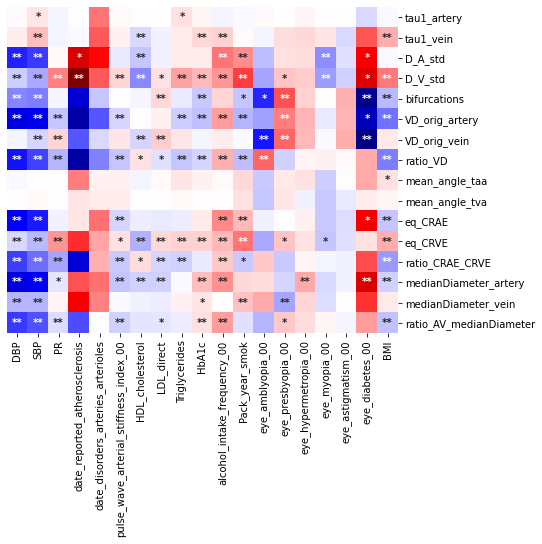

In [147]:
## This colours by beta and annotates Bonferroni-significant models with an asterisk
Bonf_thresh = -np.log10(0.05 / (log10p.shape[0] * log10p.shape[1]))
Bonf_thresh2 = -np.log10(0.001 / (log10p.shape[0] * log10p.shape[1]))

log10p_copy = log10p.copy()
log10p_copy2 = log10p.copy()
log10p_copy3 = log10p.copy()

log10p_copy= (log10p_copy>Bonf_thresh).replace({True:'*', False:''})
log10p_copy2= (log10p_copy2>Bonf_thresh2).replace({True:'*', False:''})
log10p_copy3 =log10p_copy+log10p_copy2
#print(log10p_copy3)


if file_info_name=='pheno_info_sup.csv':
    fig = plt.figure(figsize=(13, 10))
    ax2 = plt.axes()
    ax2.yaxis.set_ticks_position('right')
    ax=sns.heatmap(betas, 
                annot=log10p_copy3, #(log10p>Bonf_thresh).replace({True:'*', False:''}), 
                cbar=False,
                fmt="", annot_kws={'weight': 'bold'}, 
                vmin=-abs(betas).max().max(), 
                vmax=abs(betas).max().max(), 
                cmap='seismic', cbar_kws={'label': 'Standardised \u03B2'})
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)    
    #plt.savefig(output_dir+ str(DATE)+'_MLR_'+ventile+'_sup.jpg', facecolor='white', bbox_inches='tight', pad_inches=0.1, dpi=150)

else:
    
    fig = plt.figure(figsize=(7, 6))
    ax2 = plt.axes()
    ax2.yaxis.set_ticks_position('right')
    ax=sns.heatmap(betas, 
                annot=log10p_copy3, #(log10p>Bonf_thresh).replace({True:'*', False:''}), 
                cbar=False,
                fmt="", annot_kws={'weight': 'bold'}, 
                vmin=-abs(betas).max().max(), 
                vmax=abs(betas).max().max(), 
                cmap='seismic', cbar_kws={'label': 'Standardised \u03B2'})
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
    #plt.savefig(output_dir+ str(DATE)+'_MLR_'+ventile+'.jpg', facecolor='white', bbox_inches='tight', pad_inches=0.1, dpi=150)

#plt.close()

### cases and controls

In [146]:
list_value=[]
for i in log10p_copy3.columns:
    #print(i, df_pheno_dise[i].value_counts())
    data={
        'i': i,
        'value_counts': df_pheno_dise[i].value_counts()
    }
    list_value.append(data)
df_count_val = pd.DataFrame(list_value)
print(df_count_val)
df_count_val.to_csv(output_dir+ str(DATE)+'_N_CASES_MLR_'+ventile+'.csv', sep=',', index=False)


                                         i  \
0                                      DBP   
1                                      SBP   
2                                       PR   
3            date_reported_atherosclerosis   
4       date_disorders_arteries_arterioles   
5   pulse_wave_arterial_stiffness_index_00   
6                          HDL_cholesterol   
7                               LDL_direct   
8                            Triglycerides   
9                                    HbA1c   
10             alcohol_intake_frequency_00   
11                          Pack_year_smok   
12                        eye_amblyopia_00   
13                       eye_presbyopia_00   
14                    eye_hypermetropia_00   
15                           eye_myopia_00   
16                      eye_astigmatism_00   
17                         eye_diabetes_00   
18                                     BMI   

                                         value_counts  
0   -0.174140    1563
 